# **Plant Doctor**

In [1]:
!wget https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip .

--2025-03-26 09:11:15--  https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/spMohanty/PlantVillage-Dataset/zip/refs/heads/master [following]
--2025-03-26 09:11:15--  https://codeload.github.com/spMohanty/PlantVillage-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ]   2.33G  37.9MB/s    in 67s     

2025-03-26 09:12:23 (35.7 MB/s) - ‘master.zip’ saved [2503722083]

--2025-03-26 09:12:23--  http://./
Resolving . (.)... failed: No address associated with hostname.
w

In [ ]:
!unzip master.zip -d .

In [ ]:
import random
import numpy as np
import torch


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_random_seed(42)

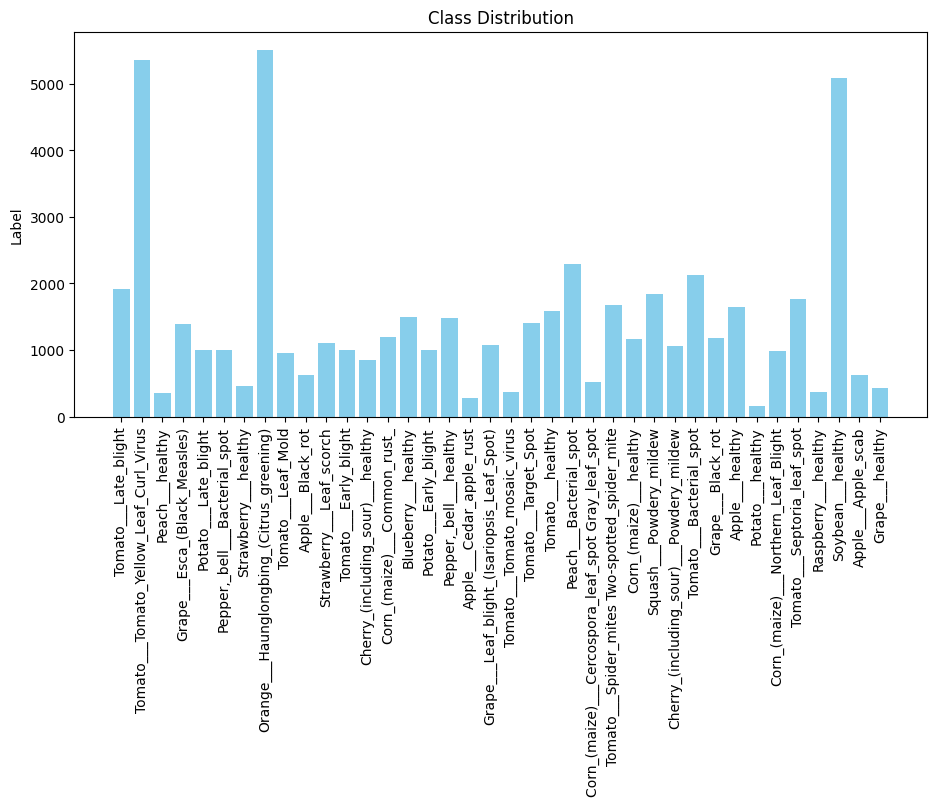

In [ ]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("PlantVillage-Dataset-master/raw")

labels = os.listdir(os.path.join(path, "color"))
counts = [
    len(os.listdir(os.path.join(os.path.join(path, "color"), label)))
    for label in labels
]

plt.figure(figsize=(11, 5))
plt.bar(labels, counts, color="skyblue")
plt.ylabel("Image count")
plt.ylabel("Label")

plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()

### Data Loading

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd


def load_data(path):
    data = []

    for p in path.iterdir():
        for image in p.iterdir():
            data.append((image, image.parents[0].stem))

    return pd.DataFrame(data, columns=["path", "label"])

In [4]:
df_rgb = load_data(path / "color")
df_seg = load_data(path / "segmented")

print(df_rgb.shape)
print(df_seg.shape)

(54305, 2)
(54306, 2)


Find the extra image among the segmented images:

In [ ]:
import re


def normalize_filename(file_path):
    file_name = file_path.stem.replace("_final_masked", "").strip().lower()
    file_name = re.sub(r"^[a-f0-9-]+___", "", file_name)
    return file_name


df_rgb["filename"] = df_rgb["path"].apply(lambda x: normalize_filename(x))
df_seg["filename"] = df_seg["path"].apply(lambda x: normalize_filename(x))

df_rgb["class"] = df_rgb["path"].apply(lambda x: x.parents[0].name)
df_seg["class"] = df_seg["path"].apply(lambda x: x.parents[0].name)


extra_in_seg = df_seg[~df_seg["filename"].isin(df_rgb["filename"])]
print("Extra image in segmented:\n", extra_in_seg[["filename", "class"]])

Extra image in segmented:
              filename                         class
8025  fam_b.msls 4430  Grape___Esca_(Black_Measles)


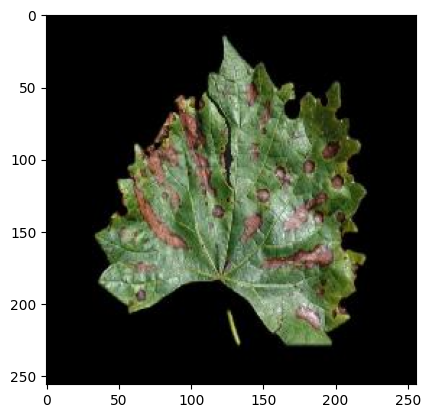

In [ ]:
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from matplotlib import pyplot as plt

sample = df_seg[df_seg["filename"].isin(extra_in_seg["filename"])].iloc[0]
img = pil_to_tensor(Image.open(sample.path)) / 255
img_np = img.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.show()

Drop the extra image:

In [ ]:
df_seg = df_seg.drop(df_seg[df_seg["filename"].isin(extra_in_seg["filename"])].index[0])

print(df_rgb.shape)
print(df_seg.shape)

(54305, 4)
(54305, 4)


Some images have more or less than 3 channels:

In [ ]:
from PIL import Image
from tqdm import tqdm


def check_image_channels(df, dataset_name):
    incorrect_channels = []

    for idx, row in tqdm(df.iterrows()):
        img = Image.open(row["path"])
        num_channels = len(img.getbands())

        if num_channels != 3:
            incorrect_channels.append((dataset_name, idx, row["path"], num_channels))

    return incorrect_channels


wrong_channels_rgb = check_image_channels(df_rgb, "RGB Dataset")
wrong_channels_seg = check_image_channels(df_seg, "Segmented Dataset")
wrong_channels = wrong_channels_rgb + wrong_channels_seg

for dataset, idx, path, channels in wrong_channels:
    print(f"[{dataset}] Image at index {idx} has {channels} channels → {path}")

54305it [02:11, 412.19it/s]
54305it [02:10, 416.28it/s]

[RGB Dataset] Image at index 26350 has 4 channels → PlantVillage-Dataset-master/raw/color/Pepper,_bell___healthy/42f083e2-272d-4f83-ad9a-573ee90e50ec___Screen Shot 2015-05-06 at 4.01.13 PM.png
[Segmented Dataset] Image at index 51784 has 1 channels → PlantVillage-Dataset-master/raw/segmented/Soybean___healthy/b32e4516-9cd7-4226-be52-26f413c97834___RS_HL 3512_final_masked.jpg


In [ ]:
# drop the images in both dataframes
df_rgb = df_rgb.drop(26350)
df_seg = df_seg.drop(51784)

In [ ]:
# drop the ones from the respective dataset, too
for_deletion_from_rgb = "Screen Shot 2015-05-06 at 4.01.13 PM"
for_deletion_from_segmented = "RS_HL 3512"

image_in_seg = df_seg[
    df_seg["path"].apply(lambda x: for_deletion_from_rgb.lower() in str(x).lower())
]
image_in_rgb = df_rgb[
    df_rgb["path"].apply(
        lambda x: for_deletion_from_segmented.lower() in str(x).lower()
    )
]

print(image_in_seg["path"])
print(image_in_rgb["path"])

26210    PlantVillage-Dataset-master/raw/segmented/Pepp...
Name: path, dtype: object
52828    PlantVillage-Dataset-master/raw/color/Soybean_...
Name: path, dtype: object


In [11]:
df_rgb = df_rgb.drop(52828)
df_seg = df_seg.drop(26210)

In [ ]:
# unify filenames
df_rgb["uuid"] = df_rgb["filename"].apply(lambda x: x.split("___")[0])
df_seg["uuid"] = df_seg["filename"].apply(lambda x: x.split("___")[0])

# ensure the same split
train_uuids, test_uuids = train_test_split(
    df_rgb["uuid"].unique(), test_size=0.2, random_state=42
)
train_uuids, valid_uuids = train_test_split(train_uuids, test_size=0.1, random_state=42)

train_df_rgb = df_rgb[df_rgb["uuid"].isin(train_uuids)]
valid_df_rgb = df_rgb[df_rgb["uuid"].isin(valid_uuids)]
test_df_rgb = df_rgb[df_rgb["uuid"].isin(test_uuids)]

train_df_seg = df_seg[df_seg["uuid"].isin(train_uuids)]
valid_df_seg = df_seg[df_seg["uuid"].isin(valid_uuids)]
test_df_seg = df_seg[df_seg["uuid"].isin(test_uuids)]

In [ ]:
df_seg = df_seg[["path", "label"]]
df_rgb = df_rgb[["path", "label"]]

print(train_df_seg.shape, train_df_rgb.shape)
print(valid_df_seg.shape, valid_df_rgb.shape)
print(test_df_seg.shape, test_df_rgb.shape)

(39129, 5) (39129, 5)
(4340, 5) (4340, 5)
(10834, 5) (10834, 5)


In [ ]:
path = Path("PlantVillage-Dataset-master/raw")

label_map = {label: i for i, label in enumerate(os.listdir(path / "color"))}
i_to_label = {i: label for label, i in label_map.items()}

for i, label in label_map.items():
    print(f"{i} : {label}")

Tomato___Late_blight : 0
Tomato___Tomato_Yellow_Leaf_Curl_Virus : 1
Peach___healthy : 2
Grape___Esca_(Black_Measles) : 3
Potato___Late_blight : 4
Pepper,_bell___Bacterial_spot : 5
Strawberry___healthy : 6
Orange___Haunglongbing_(Citrus_greening) : 7
Tomato___Leaf_Mold : 8
Apple___Black_rot : 9
Strawberry___Leaf_scorch : 10
Tomato___Early_blight : 11
Cherry_(including_sour)___healthy : 12
Corn_(maize)___Common_rust_ : 13
Blueberry___healthy : 14
Potato___Early_blight : 15
Pepper,_bell___healthy : 16
Apple___Cedar_apple_rust : 17
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 18
Tomato___Tomato_mosaic_virus : 19
Tomato___Target_Spot : 20
Tomato___healthy : 21
Peach___Bacterial_spot : 22
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 23
Tomato___Spider_mites Two-spotted_spider_mite : 24
Corn_(maize)___healthy : 25
Squash___Powdery_mildew : 26
Cherry_(including_sour)___Powdery_mildew : 27
Tomato___Bacterial_spot : 28
Grape___Black_rot : 29
Apple___healthy : 30
Potato___healthy : 31
Cor

In [ ]:
from torch.utils import data
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor


class Data(data.Dataset):
    def __init__(self, df, label_map, transforms=None):
        super().__init__()

        self.df = df

        self.label_map = label_map
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df.iloc[index]
        img = pil_to_tensor(Image.open(sample.path)) / 255

        if self.transforms is not None:
            img = img.permute(1, 2, 0).numpy()
            img = self.transforms(image=img)["image"]

        return img, self.label_map[sample.label]


train_rgb = Data(train_df_rgb, label_map)

### Data Normalization


In [ ]:
from tqdm import tqdm


def get_dataset_stats(ds):
    images = torch.stack([im[0] for im in tqdm(ds)])

    ds_mean = images.mean(dim=(0, 2, 3))
    ds_std = images.std(dim=(0, 2, 3))

    return ds_mean.tolist(), ds_std.tolist()


mean, std = get_dataset_stats(train_rgb)

print(f"Dataset stats\n  mean:\t {mean}\n  std:\t {std}")

Dataset stats
  mean:	 [0.4664084315299988, 0.4890855848789215, 0.410352885723114]
  std:	 [0.19933445751667023, 0.17507633566856384, 0.21755369007587433]


In [ ]:
mean = [0.4664084315299988, 0.4890855848789215, 0.410352885723114]
std = [0.19933445751667023, 0.17507633566856384, 0.21755369007587433]

In [157]:
def ishow(
    img, cmap="viridis", title="", fig_size=(8, 6), colorbar=False, interpolation="none"
):
    "Function `ishow` displays an image in a new window."

    # extent = (0, img.shape[1], img.shape[0], 0)
    if img.min() < 0 or img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min())

    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(
        img,
        # extent=extent,
        cmap=cmap,
        interpolation=interpolation,
    )

    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation="vertical")
    plt.show()

### Data Augmentation

In [ ]:
def show_augmentations(ds, idx, n_samples=3):
    figure = plt.figure(figsize=(8, 8))

    cols, rows = n_samples, n_samples
    sample_img, label = ds[idx]

    for i in range(1, cols * rows + 1):
        img, _ = ds[idx]

        img_np = img.permute(1, 2, 0).cpu().detach().numpy()

        if img_np.min() < 0 or img_np.max() > 1:
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(img_np)

    plt.suptitle(f"sample no {idx}, label {label}")
    plt.tight_layout()
    plt.show()


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose(
    [
        A.Resize(224, 224),  # for vgg
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=30, p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.1),
        A.GaussNoise(p=0.1),
        # A.CenterCrop(width=56, height=56),
        # A.ElasticTransform(p=0.3),
        A.CLAHE(clip_limit=2, p=0.2),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.2),
        A.Normalize(mean=mean, std=std, normalization="image_per_channel"),
        ToTensorV2(),
    ]
)

valid_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=mean, std=std, normalization="image_per_channel"),
        ToTensorV2(),
    ]
)

train_rgb = Data(train_df_rgb, label_map, train_transform)
valid_rgb = Data(valid_df_rgb, label_map, valid_transform)
test_rgb = Data(test_df_rgb, label_map, valid_transform)

train_seg = Data(train_df_seg, label_map, train_transform)
valid_seg = Data(valid_df_seg, label_map, valid_transform)
test_seg = Data(test_df_seg, label_map, valid_transform)

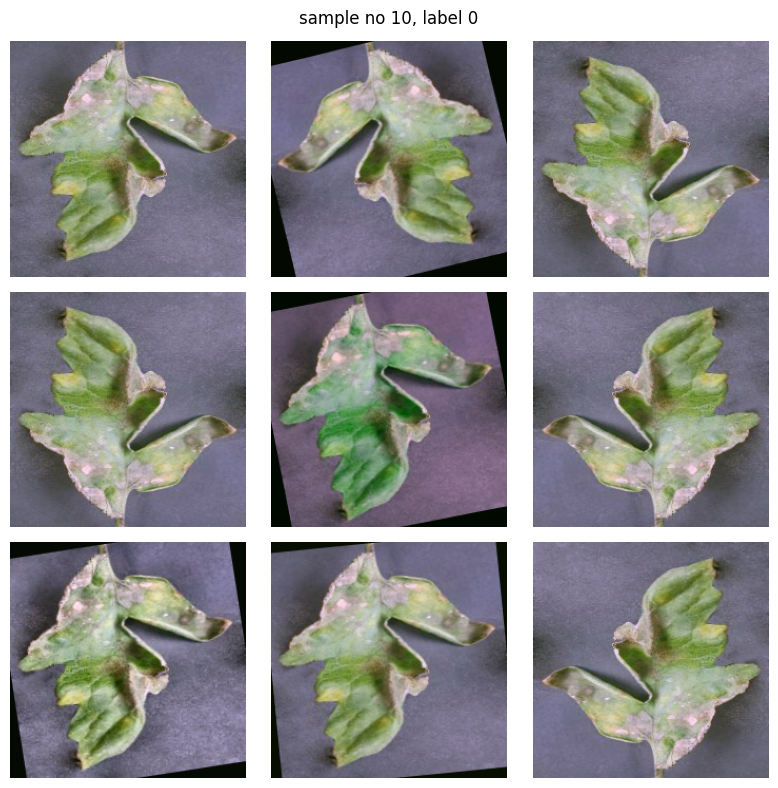

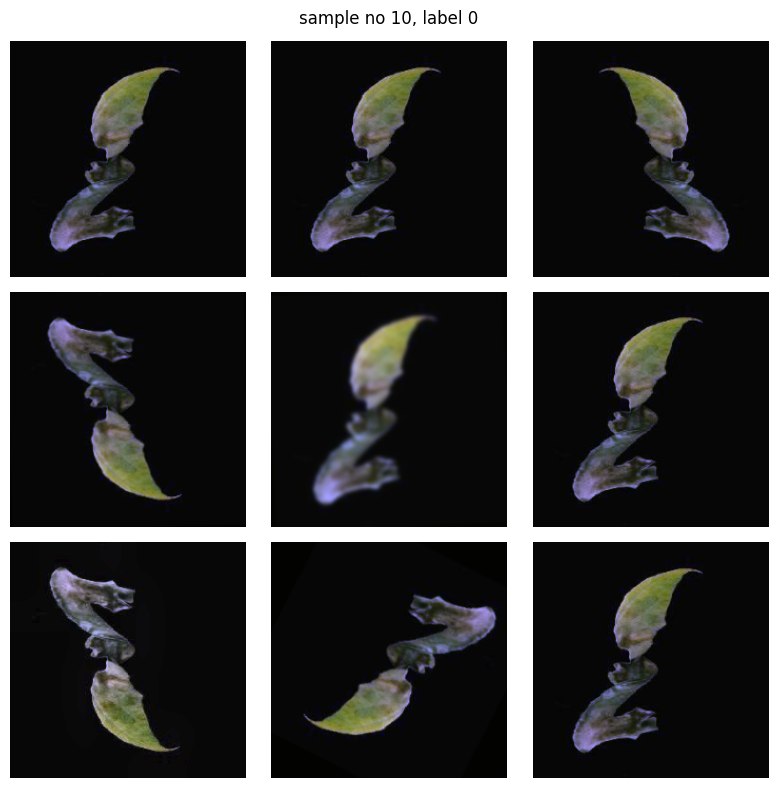

In [28]:
show_augmentations(train_rgb, 10)
show_augmentations(train_seg, 10)

#### Rebalance the classes

In [ ]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader

# (using train_df_seg is the same)
class_counts = train_df_rgb["label"].value_counts().rename("count")
class_weights = (1.0 / class_counts).rename("weight")
class_weights /= class_weights.sum()
sample_weights = train_df_rgb["label"].map(class_weights).astype(np.float32).values

sampler = WeightedRandomSampler(
    weights=sample_weights.tolist(), num_samples=len(sample_weights), replacement=True
)

In [30]:
print(pd.concat([class_counts, class_weights], axis=1))

                                                    count    weight
label                                                              
Orange___Haunglongbing_(Citrus_greening)             3970  0.003735
Tomato___Tomato_Yellow_Leaf_Curl_Virus               3822  0.003880
Soybean___healthy                                    3710  0.003997
Peach___Bacterial_spot                               1636  0.009063
Tomato___Bacterial_spot                              1525  0.009723
Tomato___Late_blight                                 1362  0.010887
Squash___Powdery_mildew                              1322  0.011216
Tomato___Septoria_leaf_spot                          1273  0.011648
Tomato___Spider_mites Two-spotted_spider_mite        1213  0.012224
Apple___healthy                                      1203  0.012326
Tomato___healthy                                     1134  0.013076
Blueberry___healthy                                  1100  0.013480
Pepper,_bell___healthy                          

### Models

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class WrappedDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):  # send only one batch to the device every iteration
        batches = iter(self.dataloader)
        for x, y in batches:
            yield x.to(self.device), y.to(self.device)


bs = 128

train_dataloader_rgb = WrappedDataLoader(
    DataLoader(train_rgb, batch_size=bs, sampler=sampler), device
)
val_dataloader_rgb = WrappedDataLoader(
    DataLoader(valid_rgb, batch_size=bs, shuffle=True), device
)
test_dataloader_rgb = WrappedDataLoader(DataLoader(test_rgb, batch_size=bs), device)

train_dataloader_seg = WrappedDataLoader(
    DataLoader(train_seg, batch_size=bs, sampler=sampler), device
)
val_dataloader_seg = WrappedDataLoader(
    DataLoader(valid_seg, batch_size=bs, shuffle=True), device
)
test_dataloader_seg = WrappedDataLoader(DataLoader(test_seg, batch_size=bs), device)

In [ ]:
import math
from copy import deepcopy


def update(model, loss_f, inputs, targets, optimizer=None):
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_f(outputs, targets)

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), len(inputs), torch.sum(preds == targets.data)


def train(epochs, model, loss_f, optimizer, scheduler, train_dl, valid_dl):
    val_loss = []
    train_loss = []
    best_acc = -math.inf
    state_dict = model.state_dict()

    for epoch in range(epochs):
        model.train()

        losses, inputs_size, _ = zip(
            *[
                update(model, loss_f, inputs, targets, optimizer)
                for inputs, targets in tqdm(train_dl)
            ]
        )

        epoch_train_loss = np.sum(np.multiply(losses, inputs_size)) / np.sum(
            inputs_size
        )
        train_loss.append(epoch_train_loss)

        scheduler.step()

        model.eval()

        with torch.no_grad():
            losses, inputs_size, corrects = zip(
                *[
                    update(model, loss_f, inputs, targets)
                    for inputs, targets in valid_dl
                ]
            )

        epoch_val_loss = np.sum(np.multiply(losses, inputs_size)) / np.sum(inputs_size)
        val_loss.append(epoch_val_loss)

        epoch_val_acc = np.sum([c.cpu().numpy() for c in corrects]) / np.sum(
            inputs_size
        )

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            state_dict = deepcopy(model.state_dict())
            print(f"New best Acc: {best_acc:4f}")

        print(
            f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_train_loss:.5f}, Validation Loss: {epoch_val_loss:.5f}"
        )

    model.load_state_dict(state_dict)
    return train_loss, val_loss

#### Train VGG19 on original RGB images

In [33]:
import torchvision.models as models
from torch import nn
from torchsummary import summary

vgg19_rgb = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)

summary(vgg19_rgb, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
for param in vgg19_rgb.features.parameters():
    param.requires_grad = False

num_in_features = vgg19_rgb.classifier[6].in_features
vgg19_rgb.classifier[6] = nn.Linear(
    in_features=num_in_features, out_features=len(label_map)
).to(device)

100%|██████████| 306/306 [12:34<00:00,  2.46s/it]


New best Acc: 0.902074
Epoch 1/1, Training Loss: 0.69064, Validation Loss: 0.30203


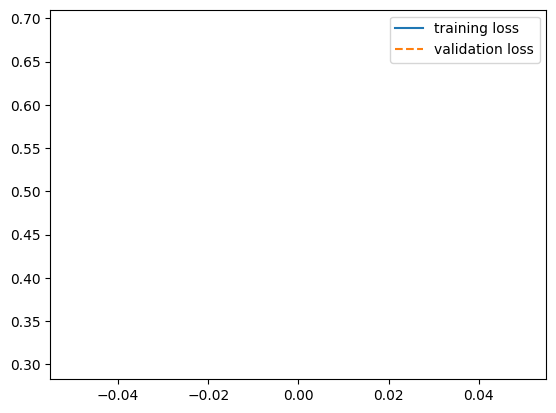

In [ ]:
import torch.optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

torch.set_float32_matmul_precision("high")

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(vgg19_rgb.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss, val_loss = train(
    epochs=1,
    model=vgg19_rgb,
    loss_f=loss_func,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dataloader_rgb,
    valid_dl=val_dataloader_rgb,
)
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle="--")
plt.legend(["training loss", "validation loss"])
plt.show()

100%|██████████| 306/306 [05:27<00:00,  1.07s/it]


New best Acc: 0.916359
Epoch 1/10, Training Loss: 0.60616, Validation Loss: 0.25716


100%|██████████| 306/306 [05:23<00:00,  1.06s/it]


Epoch 2/10, Training Loss: 0.57374, Validation Loss: 0.24843


100%|██████████| 306/306 [05:29<00:00,  1.08s/it]


New best Acc: 0.916590
Epoch 3/10, Training Loss: 0.55132, Validation Loss: 0.24134


100%|██████████| 306/306 [05:25<00:00,  1.06s/it]


New best Acc: 0.920968
Epoch 4/10, Training Loss: 0.52941, Validation Loss: 0.23428


100%|██████████| 306/306 [05:23<00:00,  1.06s/it]


New best Acc: 0.921429
Epoch 5/10, Training Loss: 0.53646, Validation Loss: 0.23396


100%|██████████| 306/306 [05:32<00:00,  1.09s/it]


Epoch 6/10, Training Loss: 0.53822, Validation Loss: 0.23342


100%|██████████| 306/306 [05:57<00:00,  1.17s/it]


New best Acc: 0.921889
Epoch 7/10, Training Loss: 0.52514, Validation Loss: 0.23305


100%|██████████| 306/306 [06:16<00:00,  1.23s/it]


Epoch 8/10, Training Loss: 0.51131, Validation Loss: 0.23266


100%|██████████| 306/306 [06:06<00:00,  1.20s/it]


Epoch 9/10, Training Loss: 0.52297, Validation Loss: 0.23258


100%|██████████| 306/306 [06:06<00:00,  1.20s/it]


New best Acc: 0.922120
Epoch 10/10, Training Loss: 0.52921, Validation Loss: 0.23252


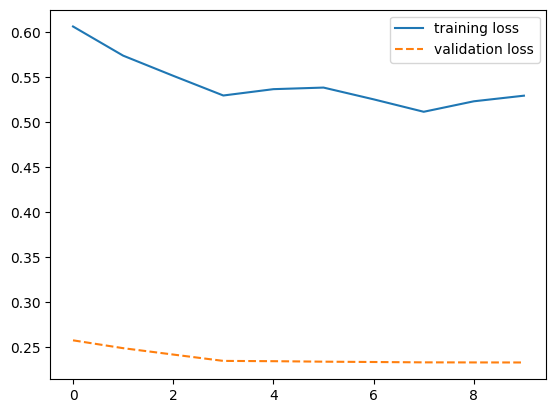

In [ ]:
for param in vgg19_rgb.parameters():
    param.requires_grad = True


optimizer = torch.optim.SGD(
    vgg19_rgb.parameters(), lr=1e-5, weight_decay=1e-4, momentum=0.9
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_loss, val_loss = train(
    epochs=10,
    model=vgg19_rgb,
    loss_f=loss_func,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dataloader_rgb,
    valid_dl=val_dataloader_rgb,
)

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle="--")
plt.legend(["training loss", "validation loss"])
plt.show()

In [ ]:
torch.save(vgg19_rgb.state_dict(), "vgg19_rgb_model.pth")

#### Train VGG19 on the segmented images

In [ ]:
vgg19_seg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)

for param in vgg19_seg.features.parameters():
    param.requires_grad = False

num_in_features = vgg19_seg.classifier[6].in_features
vgg19_seg.classifier[6] = nn.Linear(
    in_features=num_in_features, out_features=len(label_map)
).to(device)

100%|██████████| 306/306 [04:13<00:00,  1.21it/s]


New best Acc: 0.790323
Epoch 1/10, Training Loss: 1.87380, Validation Loss: 0.70326


100%|██████████| 306/306 [04:05<00:00,  1.25it/s]


New best Acc: 0.847235
Epoch 2/10, Training Loss: 1.04053, Validation Loss: 0.51142


100%|██████████| 306/306 [04:09<00:00,  1.22it/s]


New best Acc: 0.865899
Epoch 3/10, Training Loss: 0.86636, Validation Loss: 0.43475


100%|██████████| 306/306 [04:13<00:00,  1.21it/s]


New best Acc: 0.874194
Epoch 4/10, Training Loss: 0.77285, Validation Loss: 0.39556


100%|██████████| 306/306 [04:14<00:00,  1.20it/s]


New best Acc: 0.882949
Epoch 5/10, Training Loss: 0.72119, Validation Loss: 0.36957


100%|██████████| 306/306 [04:18<00:00,  1.19it/s]


New best Acc: 0.884332
Epoch 6/10, Training Loss: 0.68603, Validation Loss: 0.35509


100%|██████████| 306/306 [04:04<00:00,  1.25it/s]


New best Acc: 0.887097
Epoch 7/10, Training Loss: 0.66965, Validation Loss: 0.35205


100%|██████████| 306/306 [04:03<00:00,  1.26it/s]


New best Acc: 0.888018
Epoch 8/10, Training Loss: 0.67292, Validation Loss: 0.34861


100%|██████████| 306/306 [04:20<00:00,  1.17it/s]


New best Acc: 0.890323
Epoch 9/10, Training Loss: 0.66754, Validation Loss: 0.34570


100%|██████████| 306/306 [04:28<00:00,  1.14it/s]


New best Acc: 0.891705
Epoch 10/10, Training Loss: 0.66157, Validation Loss: 0.34395


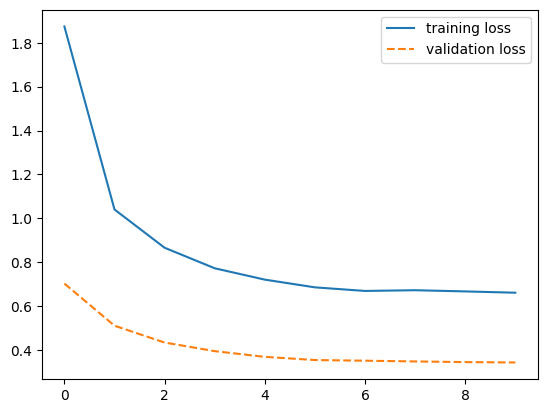

In [ ]:
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(vgg19_seg.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss, val_loss = train(
    epochs=10,
    model=vgg19_seg,
    loss_f=loss_func,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dataloader_seg,
    valid_dl=val_dataloader_seg,
)
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle="--")
plt.legend(["training loss", "validation loss"])
plt.show()

100%|██████████| 306/306 [06:14<00:00,  1.22s/it]


New best Acc: 0.895392
Epoch 1/10, Training Loss: 0.62227, Validation Loss: 0.31176


100%|██████████| 306/306 [06:11<00:00,  1.22s/it]


New best Acc: 0.898618
Epoch 2/10, Training Loss: 0.59179, Validation Loss: 0.29858


100%|██████████| 306/306 [06:00<00:00,  1.18s/it]


New best Acc: 0.902535
Epoch 3/10, Training Loss: 0.57151, Validation Loss: 0.28815


100%|██████████| 306/306 [06:12<00:00,  1.22s/it]


New best Acc: 0.904608
Epoch 4/10, Training Loss: 0.55114, Validation Loss: 0.27947


100%|██████████| 306/306 [05:59<00:00,  1.17s/it]


New best Acc: 0.905300
Epoch 5/10, Training Loss: 0.53607, Validation Loss: 0.27858


100%|██████████| 306/306 [05:44<00:00,  1.13s/it]


Epoch 6/10, Training Loss: 0.54256, Validation Loss: 0.27808


100%|██████████| 306/306 [06:07<00:00,  1.20s/it]


Epoch 7/10, Training Loss: 0.53411, Validation Loss: 0.27682


100%|██████████| 306/306 [05:42<00:00,  1.12s/it]


Epoch 8/10, Training Loss: 0.54349, Validation Loss: 0.27638


100%|██████████| 306/306 [05:49<00:00,  1.14s/it]


Epoch 9/10, Training Loss: 0.53209, Validation Loss: 0.27630


100%|██████████| 306/306 [05:33<00:00,  1.09s/it]


New best Acc: 0.905530
Epoch 10/10, Training Loss: 0.54106, Validation Loss: 0.27617


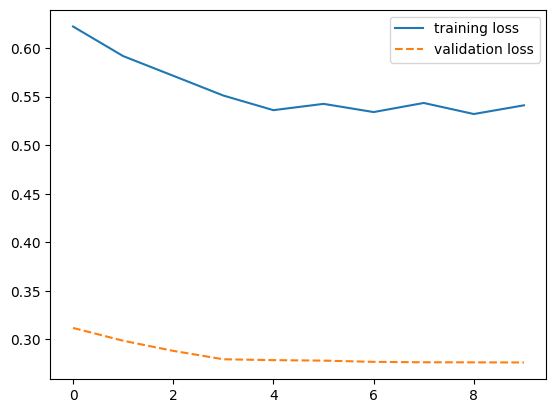

In [ ]:
for param in vgg19_seg.parameters():
    param.requires_grad = True


optimizer = torch.optim.SGD(
    vgg19_seg.parameters(), lr=1e-5, weight_decay=1e-4, momentum=0.9
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_loss, val_loss = train(
    epochs=10,
    model=vgg19_seg,
    loss_f=loss_func,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dataloader_seg,
    valid_dl=val_dataloader_seg,
)

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle="--")
plt.legend(["training loss", "validation loss"])
plt.show()

In [ ]:
torch.save(vgg19_seg.state_dict(), "vgg19_seg_model.pth")

### Create an Ensamble

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, color, segmented):
        super().__init__()
        self.vgg19_rgb = color
        self.vgg19_segmented = segmented
        self.classifier = nn.Linear(len(label_map) * 2, len(label_map))

    def forward(self, x):
        x1 = self.vgg19_rgb(x)
        x2 = self.vgg19_segmented(x)
        x = torch.cat((x1, x2), dim=1)
        out = self.classifier(x)
        return out


ensemble_model = EnsembleModel(vgg19_rgb, vgg19_seg)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True

ensemble_model = ensemble_model.to(device)

100%|██████████| 306/306 [05:07<00:00,  1.00s/it]


New best Acc: 0.863825
Epoch 1/10, Training Loss: 1.35403, Validation Loss: 0.46419


100%|██████████| 306/306 [05:15<00:00,  1.03s/it]


New best Acc: 0.880645
Epoch 2/10, Training Loss: 0.71562, Validation Loss: 0.37672


100%|██████████| 306/306 [05:15<00:00,  1.03s/it]


New best Acc: 0.886175
Epoch 3/10, Training Loss: 0.64939, Validation Loss: 0.34898


100%|██████████| 306/306 [05:17<00:00,  1.04s/it]


New best Acc: 0.898848
Epoch 4/10, Training Loss: 0.61966, Validation Loss: 0.31860


100%|██████████| 306/306 [05:31<00:00,  1.08s/it]


Epoch 5/10, Training Loss: 0.60322, Validation Loss: 0.32164


100%|██████████| 306/306 [05:24<00:00,  1.06s/it]


New best Acc: 0.903917
Epoch 6/10, Training Loss: 0.58195, Validation Loss: 0.30062


100%|██████████| 306/306 [05:15<00:00,  1.03s/it]


New best Acc: 0.905530
Epoch 7/10, Training Loss: 0.57423, Validation Loss: 0.29691


100%|██████████| 306/306 [05:13<00:00,  1.02s/it]


Epoch 8/10, Training Loss: 0.56977, Validation Loss: 0.29869


100%|██████████| 306/306 [04:48<00:00,  1.06it/s]


Epoch 9/10, Training Loss: 0.56547, Validation Loss: 0.29850


100%|██████████| 306/306 [04:42<00:00,  1.08it/s]


Epoch 10/10, Training Loss: 0.56995, Validation Loss: 0.29643


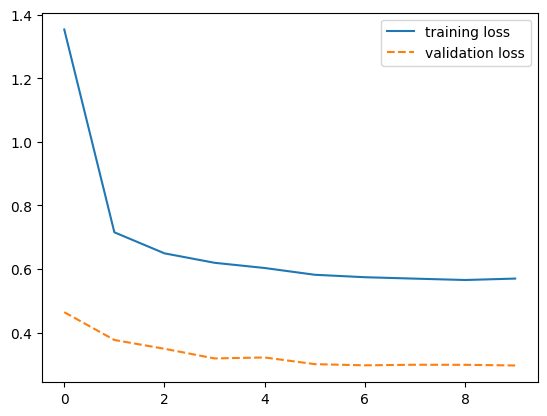

In [ ]:
optimizer = torch.optim.SGD(
    ensemble_model.parameters(), lr=1e-3, weight_decay=1e-4, momentum=0.9
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

train_loss, val_loss = train(
    epochs=10,
    model=ensemble_model,
    loss_f=loss_func,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dataloader_rgb,
    valid_dl=val_dataloader_rgb,
)

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss, linestyle="--")
plt.legend(["training loss", "validation loss"])
plt.show()

In [ ]:
torch.save(vgg19_seg.state_dict(), "ensemble_model.pth")

### Evaluation

In [122]:
loss_func_eval = nn.CrossEntropyLoss(reduction="none")


def evaluate(model, test_dl):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for batch, targets in tqdm(test_dl):
            batch, targets = batch.to(device), targets.to(device)

            outputs = model(batch)
            _, preds = torch.max(outputs, 1)

            loss = loss_func_eval(outputs, targets)
            losses.extend(loss.cpu().numpy())

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred, np.array(losses)

In [155]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


def get_top_n_loss_idx(losses_np: np.array, n: int = 9):
    top_n_losses_i = (-losses_np).argsort()[:n]
    return top_n_losses_i


def plot_top_losses(
    ds: Data, losses_np: np.array, y_pred, n: int = 9, title: str = "Top losses"
):
    grid_size = int(math.sqrt(n))
    top_n_losses_i = get_top_n_loss_idx(losses_np, n)

    images = [ds[i] for i in top_n_losses_i]
    fig = plt.figure(figsize=(20, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(grid_size, grid_size), axes_pad=0.8)

    fig.suptitle(title, fontsize=16)
    predicted = np.array(y_pred)[top_n_losses_i]
    top_n_losses = losses_np[top_n_losses_i]

    for ax, img_label, y_predicted, loss in zip(grid, images, predicted, top_n_losses):
        img, label = img_label

        title = f"Prediction: {i_to_label[y_predicted.item()]} \n  Actual: {i_to_label[label]} \n  Loss: {loss:.2f}"
        img_np = img.permute(1, 2, 0).cpu().detach().numpy()
        if img_np.min() < 0 or img_np.max() > 1:
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        ax.imshow(img_np)
        ax.set_title(title)

    plt.show()

In [124]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def print_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print(
        "\nClassification Report:\n",
        classification_report(y_true, y_pred, target_names=class_names),
    )

#### VGG19 on original RGB images

100%|██████████| 85/85 [01:08<00:00,  1.24it/s]


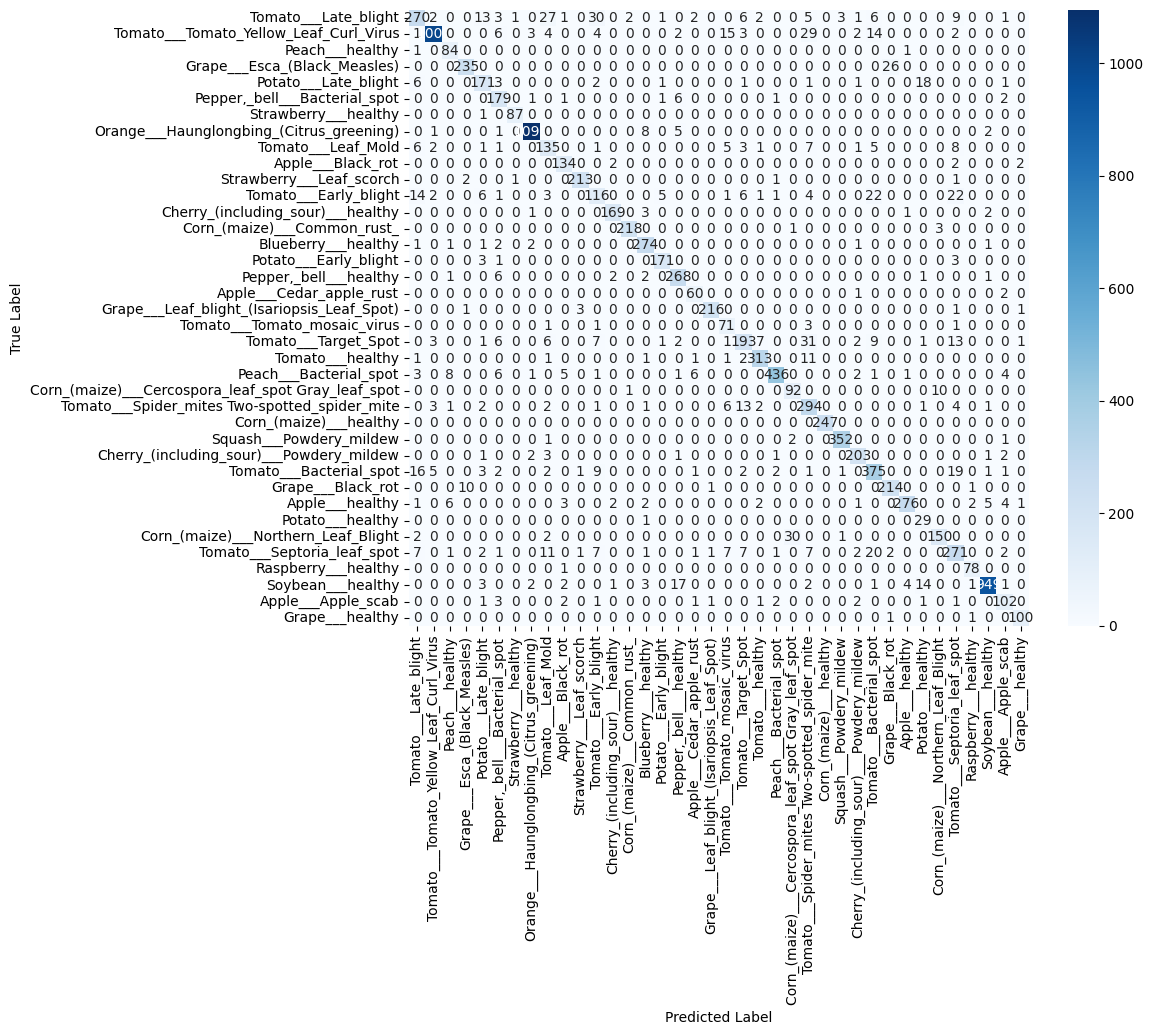


Classification Report:
                                                     precision    recall  f1-score   support

                              Tomato___Late_blight       0.82      0.70      0.76       385
            Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.92      0.95      1087
                                   Peach___healthy       0.82      0.98      0.89        86
                      Grape___Esca_(Black_Measles)       0.95      0.90      0.92       261
                              Potato___Late_blight       0.82      0.83      0.83       205
                     Pepper,_bell___Bacterial_spot       0.81      0.94      0.87       191
                              Strawberry___healthy       0.98      0.99      0.98        88
          Orange___Haunglongbing_(Citrus_greening)       0.99      0.98      0.99      1112
                                Tomato___Leaf_Mold       0.68      0.77      0.72       176
                                 Apple___Black_rot    

In [125]:
y_true, y_pred, losses = evaluate(vgg19_rgb, test_dataloader_rgb)
print_confusion_matrix(y_true, y_pred, list(label_map.keys()))

accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

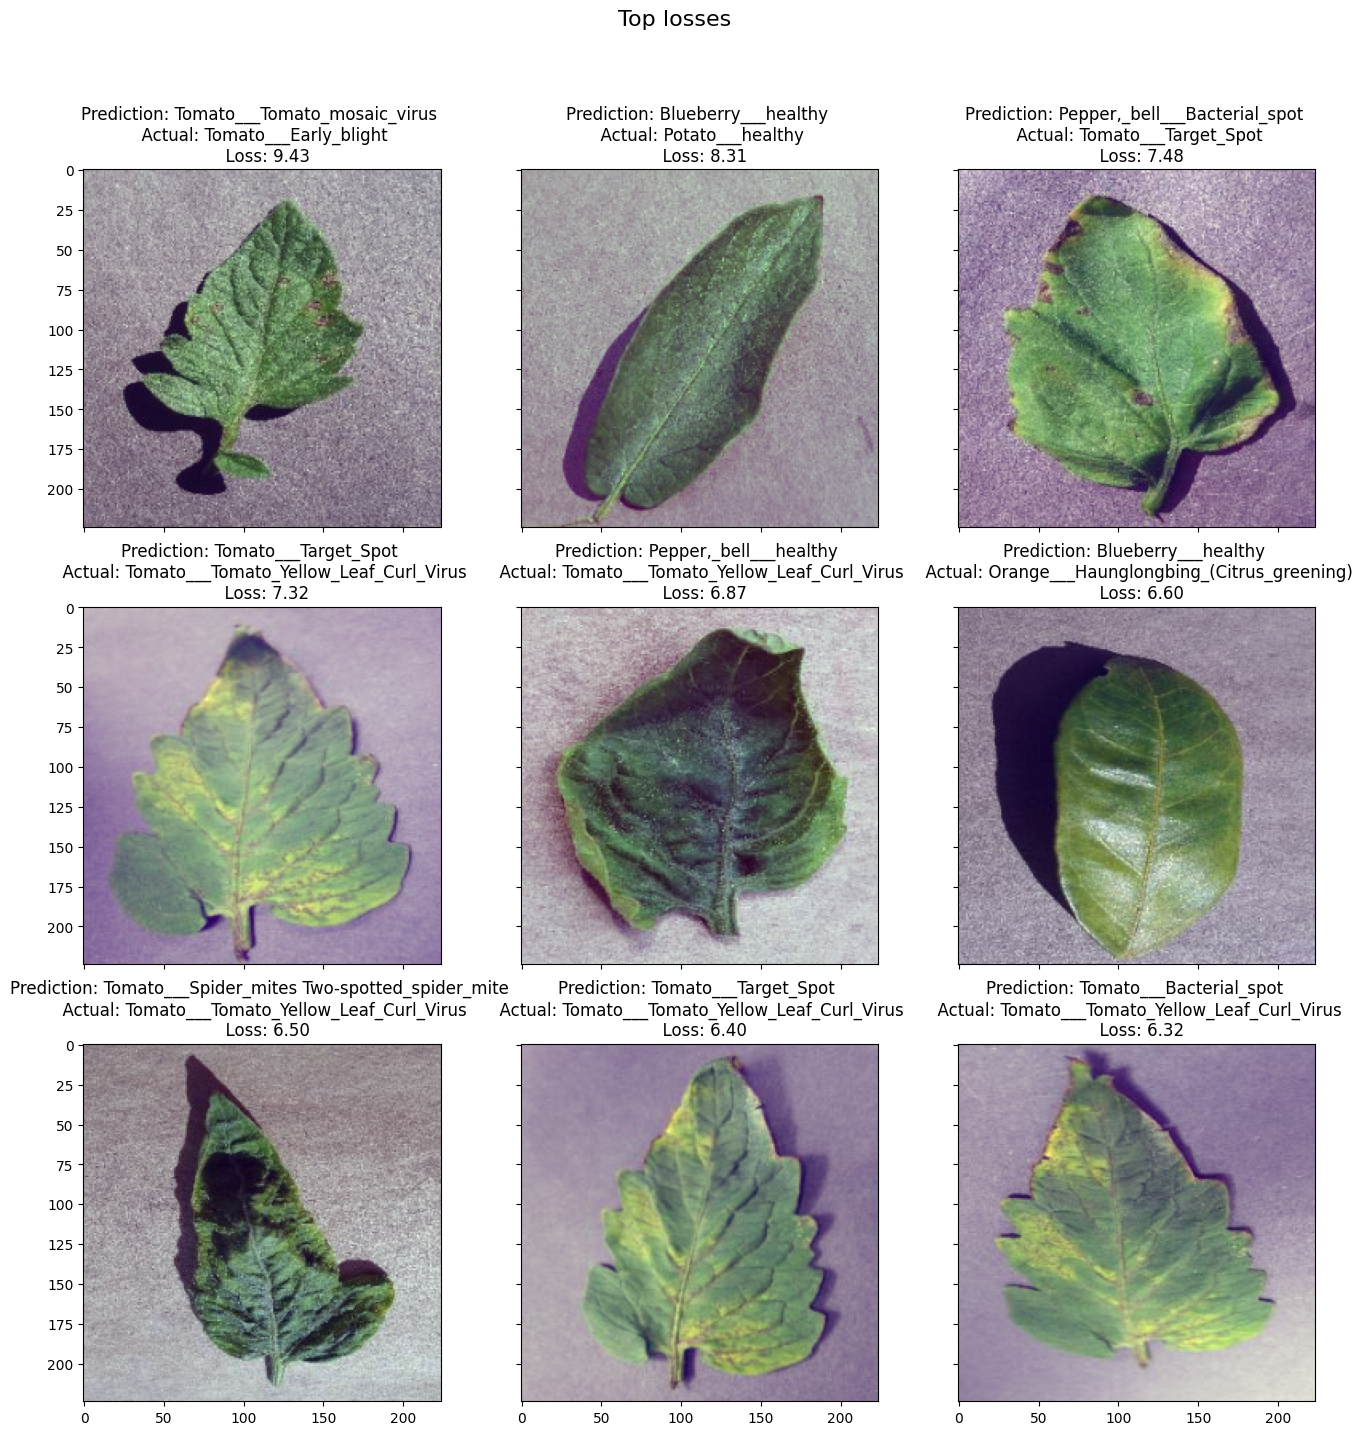

In [156]:
plot_top_losses(test_rgb, losses, y_pred, 9)

In [134]:
df, indx = plot_top_losses(test_rgb, losses, y_pred, 9)

#### VGG19 on segmented RGB images

100%|██████████| 85/85 [00:48<00:00,  1.74it/s]


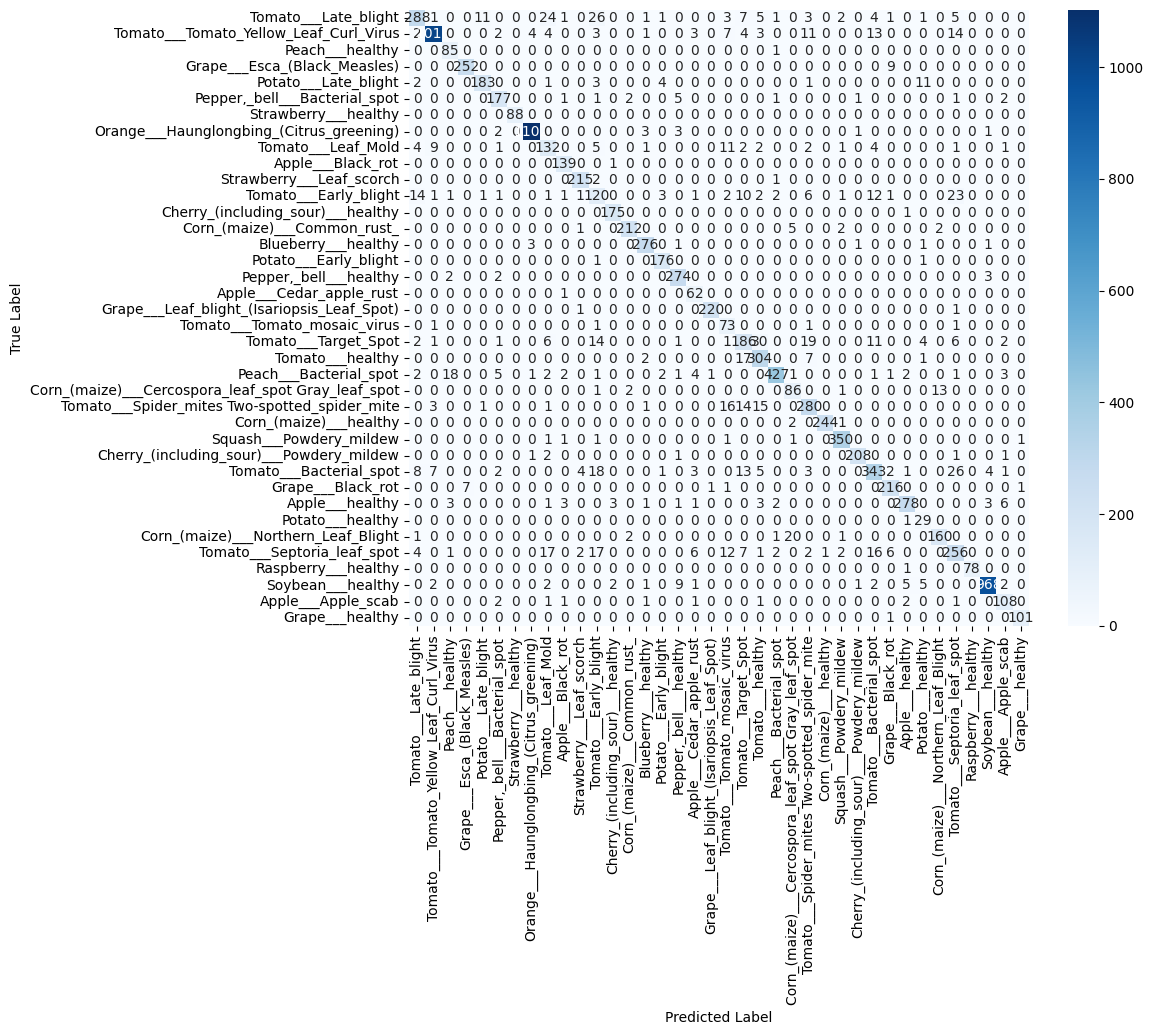


Classification Report:
                                                     precision    recall  f1-score   support

                              Tomato___Late_blight       0.88      0.75      0.81       385
            Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.93      0.95      1087
                                   Peach___healthy       0.77      0.99      0.87        86
                      Grape___Esca_(Black_Measles)       0.97      0.97      0.97       261
                              Potato___Late_blight       0.93      0.89      0.91       205
                     Pepper,_bell___Bacterial_spot       0.91      0.93      0.92       191
                              Strawberry___healthy       1.00      1.00      1.00        88
          Orange___Haunglongbing_(Citrus_greening)       0.99      0.99      0.99      1112
                                Tomato___Leaf_Mold       0.68      0.75      0.71       176
                                 Apple___Black_rot    

In [111]:
y_true, y_pred, losses = evaluate(vgg19_seg, test_dataloader_seg)

print_confusion_matrix(y_true, y_pred, list(label_map.keys()))
accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

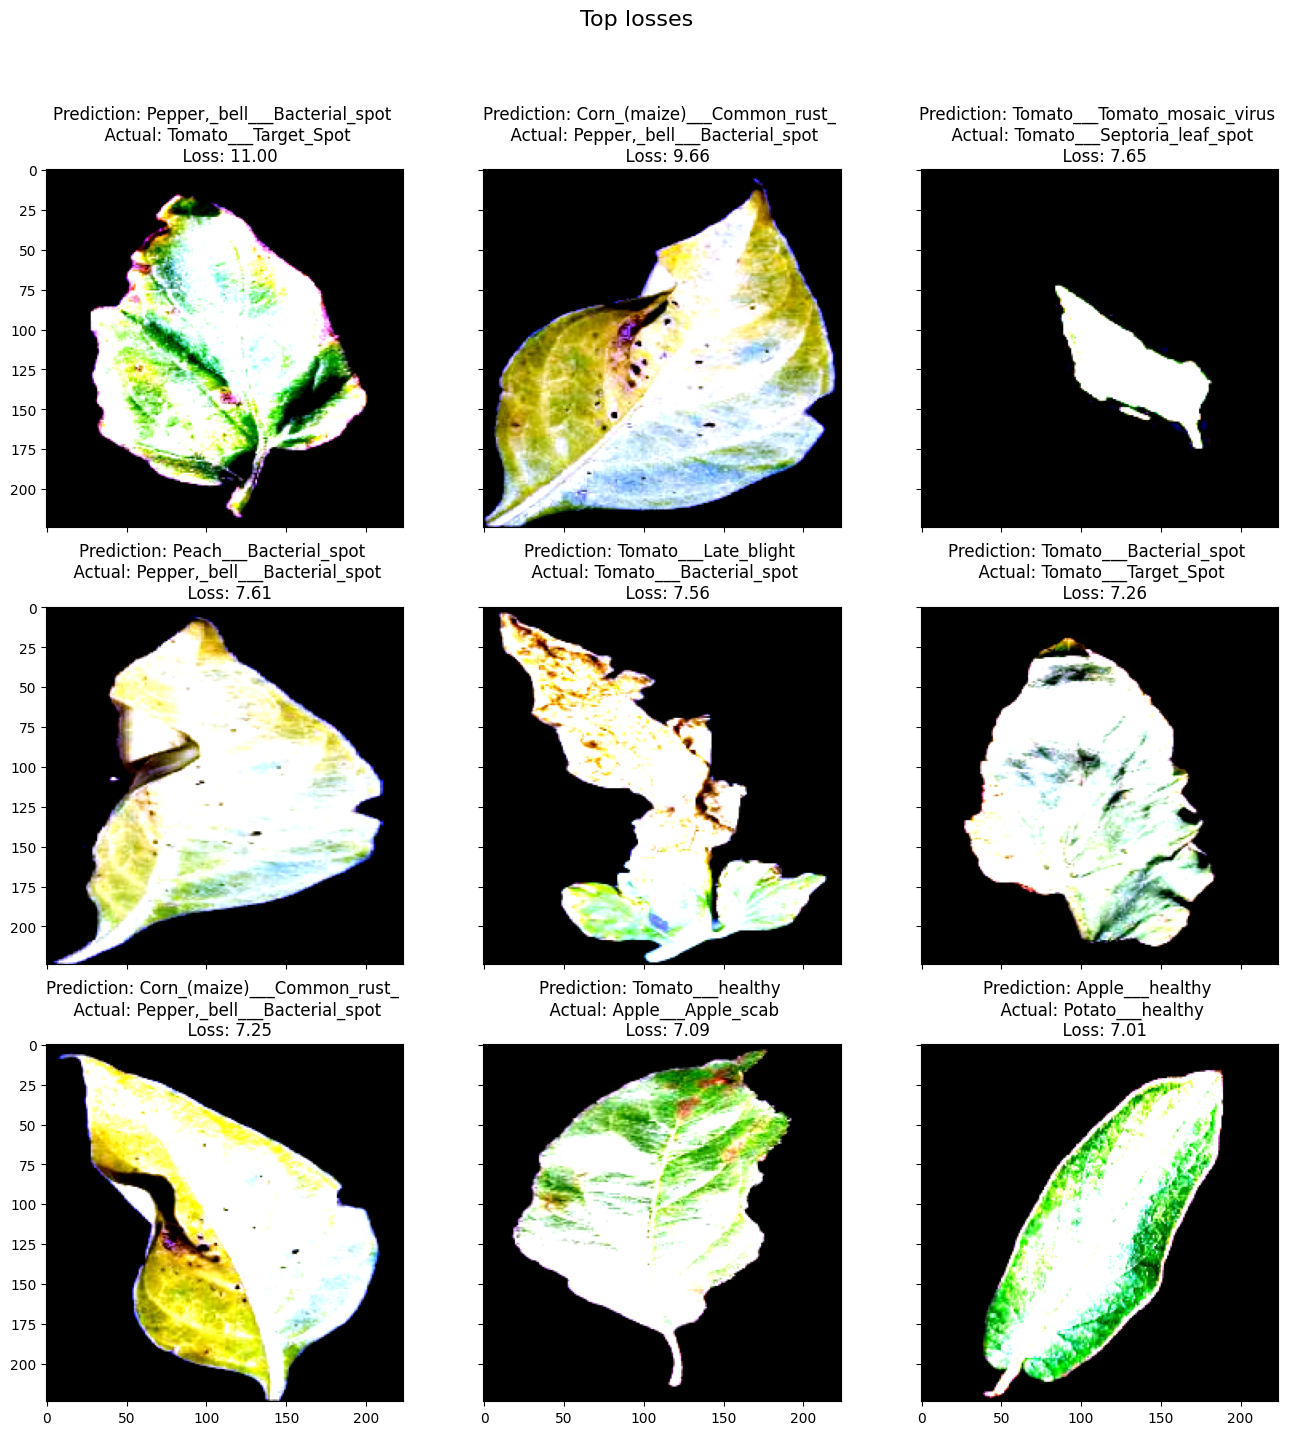

In [112]:
plot_top_losses(test_seg, losses, y_pred, 9)

#### Ensemble Model


100%|██████████| 85/85 [01:04<00:00,  1.32it/s]


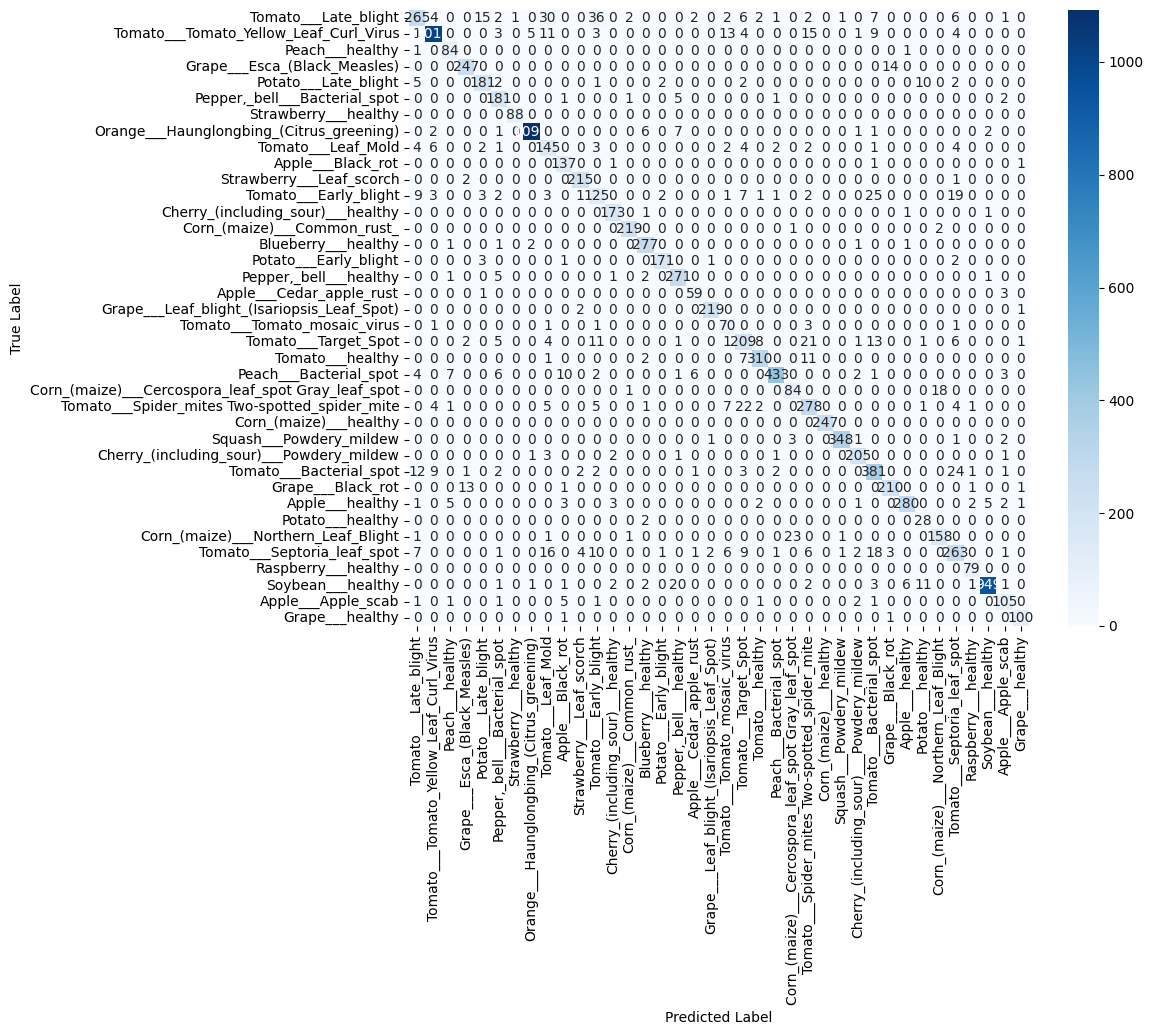


Classification Report:
                                                     precision    recall  f1-score   support

                              Tomato___Late_blight       0.85      0.69      0.76       385
            Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.94      0.95      1087
                                   Peach___healthy       0.84      0.98      0.90        86
                      Grape___Esca_(Black_Measles)       0.93      0.95      0.94       261
                              Potato___Late_blight       0.88      0.88      0.88       205
                     Pepper,_bell___Bacterial_spot       0.85      0.95      0.89       191
                              Strawberry___healthy       0.99      1.00      0.99        88
          Orange___Haunglongbing_(Citrus_greening)       0.99      0.98      0.99      1112
                                Tomato___Leaf_Mold       0.66      0.82      0.73       176
                                 Apple___Black_rot    

In [113]:
y_true, y_pred, losses = evaluate(ensemble_model, test_dataloader_rgb)

print_confusion_matrix(y_true, y_pred, list(label_map.keys()))
accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

In [120]:
plot_top_losses(test_rgb, losses, y_pred, 9)

NameError: name 'losses' is not defined

In [38]:
vgg19_rgb.train(False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
import gradio as gr


def classify_image(img):
    img_torch = valid_transform(image=img.astype(np.float32))["image"]
    logits = vgg19_rgb(img_torch.unsqueeze(0).to("cuda"))
    probs = torch.nn.functional.softmax(logits)
    # predicted_class = torch.argmax(probs)
    return dict(
        zip(
            [label.replace("___", " ").replace("_", " ") for label in label_map.keys()],
            probs.tolist()[0],
        )
    )  # Map categories to their probabilities


image = gr.Image(width=224, height=224)
label = gr.Label()


intf = gr.Interface(fn=classify_image, inputs=image, outputs=label)
intf.launch(share=True)

* Running on local URL:  http://127.0.0.1:7873
* Running on public URL: https://8e6fd54a96bbeaa2e0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


torch.Size([3, 224, 224])


/tmp/ipykernel_182551/3105347385.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


torch.Size([3, 224, 224])


/tmp/ipykernel_182551/3105347385.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)
